In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
train = pd.read_csv('train_6BJx641.csv')
test = pd.read_csv('test_pavJagI.csv')


In [3]:
df = train[['datetime', 'electricity_consumption']]
df.head()

,datetime,electricity_consumption
0,2013-07-01 00:00:00,216.0
1,2013-07-01 01:00:00,210.0
2,2013-07-01 02:00:00,225.0
3,2013-07-01 03:00:00,216.0
4,2013-07-01 04:00:00,222.0


In [4]:
df.tail()

,datetime,electricity_consumption
26491,2017-06-23 19:00:00,225.0
26492,2017-06-23 20:00:00,213.0
26493,2017-06-23 21:00:00,213.0
26494,2017-06-23 22:00:00,210.0
26495,2017-06-23 23:00:00,210.0


In [5]:
# convert date column to a date time object
df['datetime'] = pd.to_datetime(df['datetime'])

# create date related features to be used for EDA and Supervised ML: Regression
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)


# Split the series to predict the last 1 week of month March
temp_df = df.set_index('datetime')
train_df = temp_df.loc[: '2017-03-01 00:00:00'].reset_index(drop=False)
test_df = temp_df.loc['2017-03-01 00:00:00':].reset_index(drop=False)

train_df.head()

,datetime,electricity_consumption,year,month,day,weekday
0,2013-07-01 00:00:00,216.0,2013,7,1,7
1,2013-07-01 01:00:00,210.0,2013,7,1,7
2,2013-07-01 02:00:00,225.0,2013,7,1,7
3,2013-07-01 03:00:00,216.0,2013,7,1,7
4,2013-07-01 04:00:00,222.0,2013,7,1,7


In [7]:
len(train_df), len(test_df), len(df)

(24289, 2208, 26496)

In [10]:
train_df.head()

,datetime,electricity_consumption,year,month,day,weekday
0,2013-07-01 00:00:00,216.0,2013,7,1,7
1,2013-07-01 01:00:00,210.0,2013,7,1,7
2,2013-07-01 02:00:00,225.0,2013,7,1,7
3,2013-07-01 03:00:00,216.0,2013,7,1,7
4,2013-07-01 04:00:00,222.0,2013,7,1,7


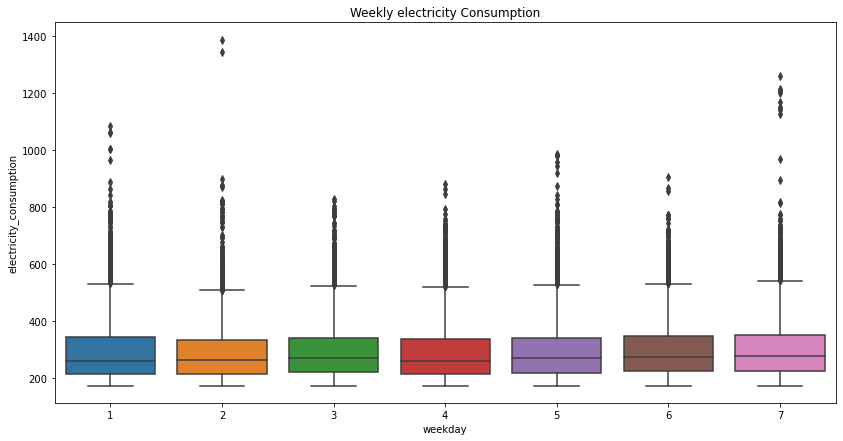

In [11]:
plt.figure(figsize=(14,7))
plot = sns.boxplot(x='weekday', y='electricity_consumption', data=df)
_ = plot.set(title='Weekly electricity Consumption')

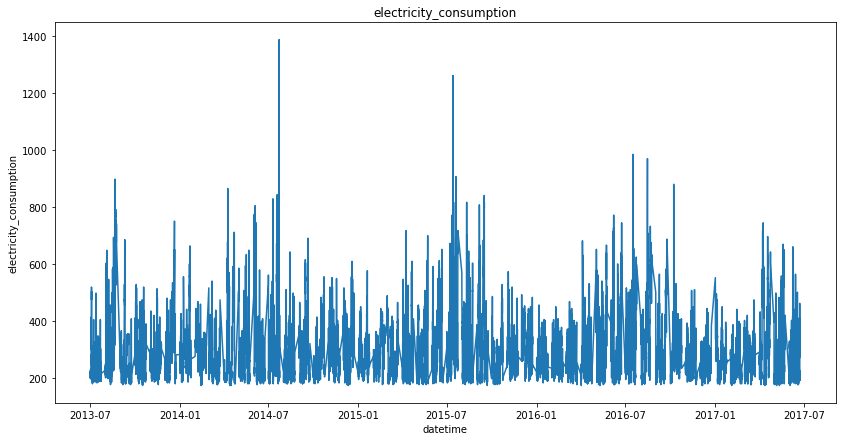

In [14]:
target = 'electricity_consumption'
plt.figure(figsize=(14,7))
plot = sns.lineplot(x='datetime', y=target, data=df)
_ = plot.set(title=target)

Seasonal Naive Bayes Model

In [22]:
# subtract 1 week from test data
dates = (test_df['datetime'] - np.timedelta64(1, 'M') + np.timedelta64(1, 'W')).values.astype('datetime64[D]')
seasonal_naive_elec_dist = train_df[train_df['datetime'].astype('datetime64[D]').isin(dates)][target]

# make a copy of the test_df and make naive predictions for the last 1 week of march
sn_pred_df = test_df.copy().drop(target, axis=1)
sn_pred_df['seasonal_naive_elec_dist'] = pd.DataFrame(seasonal_naive_elec_dist).set_index(test_df.index)
sn_pred_df.head()

ValueError: Length mismatch: Expected 456 rows, received array of length 2208

In [19]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))
def rmse(err):
    return np.sqrt(np.mean(err ** 2))
def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err)) / np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'), total_sn_pred_sales =
                                           ('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))

plt.figure(figsize=(14, 6))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecast with actual sales and errors')
plt.show()

result_df

25

In [25]:
# Time Series Decomposition
ts_decomp_df = train_df.set_index('datetime')
ts_decomp_df['electricity_consumption'] = ts_decomp_df[target].astype(float)
ts_decomp_df.head()

,electricity_consumption,year,month,day,weekday
datetime,,,,,
2013-07-01 00:00:00,216.0,2013,7,1,7
2013-07-01 01:00:00,210.0,2013,7,1,7
2013-07-01 02:00:00,225.0,2013,7,1,7
2013-07-01 03:00:00,216.0,2013,7,1,7
2013-07-01 04:00:00,222.0,2013,7,1,7


<Figure size 432x288 with 0 Axes>

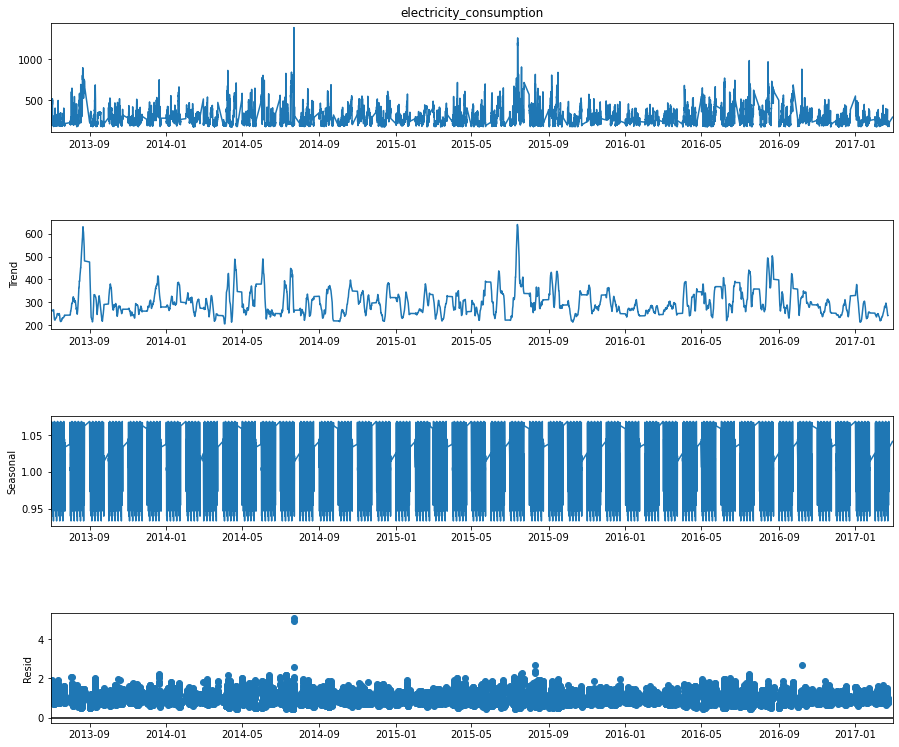

In [26]:
result = seasonal_decompose(ts_decomp_df[target], model='multiplicative', freq=120)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

In [63]:
hw_train_df = train_df[['datetime', target]].set_index('datetime')
hw_test_df = test_df[['datetime', target]].set_index('datetime')
# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, seasonal='add', seasonal_periods=3)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[500]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df,  seasonal='add', trend='add',
                                  seasonal_periods=3, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=True)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0]),
                       name='pred_sales').reset_index()

print('Forecastes made, ready for evaluation')

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [57]:
len(hw_test_df)

2208

In [50]:
# merge predictions and actual sales into one df

errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='datetime', right_on='index')
errors_df_hw = errors_df_hw[['datetime', target, 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw[target] - errors_df_hw.pred_sales

errors_df_hw.insert(0, 'model', 'Holt-Winters')

# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,6))
plt.plot(train_df['datetime'], train_df[target], label='Train')
plt.plot(test_df['datetime'], test_df[target], label='Test')
plt.plot(errors_df_hw['datetime'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('datetime')
plt.ylabel(target)
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(errors_df_hw['datetime'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['datetime'], errors_df_hw[target], label='actual sales')
plt.plot(errors_df_hw['datetime'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('datetime')
plt.ylabel(target)
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=(target, 'sum'),
                                                total_pred_sales=('pred_sales', 'sum'),
                                                holt_winters_overall_error=('errors', 'sum'),
                                                MAE=('errors', mae),
                                                RMSE=('errors', rmse),
                                                MAPE=('errors', mape))

result_df_hw

KeyError: 'index'